In [1]:
#####################to be fixed!!

#!/usr/bin/env pythonP
# coding: utf-8

import netCDF4 as nc
import sys, os, argparse
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm
#Import packages for plotting
from matplotlib.colors import ListedColormap
from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata


year = 2009
season = "JAS"
tmin=61

time_steps_per_day=4
print(f"Processing year {year}, season {season}")


IC_resolution = 0.5
dt = 0.0025
DT = 0.1
# Format the variables
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"


NCores=32
distance = 0
formatted_d=str(0)
spar=0
formatted_spar = f"{spar:.2f}"
formatted_distance = f"{distance:.2f}"


# Get the parent directory
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
FTLE_parent_directory = "/cluster/home/llpui9007/Programs/FTLE"
TBarrier_parent_directory = "/cluster/home/llpui9007/Programs/TBarrier-main/TBarrier/2D"


# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")
sys.path.append(FTLE_parent_directory)
# add utils folder to current working path
sys.path.append(TBarrier_parent_directory+"/subfunctions/utils")
sys.path.append(TBarrier_parent_directory+"/subfunctions/integration")
# add FTLE folder to current working path
sys.path.append(TBarrier_parent_directory+"/demos/AdvectiveBarriers/FTLE2D")


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
from parallelised_functions import split

# Import linear interpolation function for unsteady flow field with irregular grid
from Interpolant import generate_mask_interpolator , generate_velocity_interpolants, interpolant_unsteady_FTLE, interpolant_FTLE
# Import function to compute flow map/particle trajectories
from regular_regrid import regular_grid_interpolation_scalar

# Import function to compute finite time Lyapunov exponent (FTLE)
from FTLE import parallel_FTLE
from polar_rotation import polar_rotation_rx 
from days_since_to_date import days_since_to_date
from calculating_borders import borders_binary


Processing year 2009, season JAS


In [2]:
def plotpolar_ftle(X_domain, Y_domain, FTLE, vmin, vmax): 
  
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain),np.array(X_domain),-90) 

    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots( 
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose a colormap (e.g., 'viridis')
    cmap = 'viridis'
    cax = ax.scatter(np.asarray(X_domain_rot.ravel())[0,:], np.asarray(Y_domain_rot.ravel())[0,:], c= np.asarray(FTLE.ravel())[:], cmap= cmap,transform=ccrs.PlateCarree(), s=8,vmin=vmin,vmax=vmax)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))
    cbar.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust '14' to your desired tick size
    cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])

    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Save and show the plot 
    plt.tight_layout() 
    plt.show() 
    plt.close(fig)  # Close the figure to free up memory

def plotpolar_ftle_avg_2(X_domain, Y_domain, FTLE, borders_avg, vmin, vmax, t0, t1, tmin, K, pmin, measure,figname): 
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90) 
    # Create a figure with a polar stereographic projection centered on the North Pole 
    fig, ax = plt.subplots(
        figsize=(8, 8), 
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection 
    ) 
    # Choose colormaps
    cmap_ftle = 'seismic'
    cmap_avg = 'Greys'
    # Plot FTLE data
    cax = ax.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(FTLE.ravel())[:], 
        cmap=cmap_ftle, 
        transform=ccrs.PlateCarree(), 
        s=8, 
        vmin=vmin, 
        vmax=vmax
    )
    # Plot borders_avg data
    cax_avg = ax.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(borders_avg.ravel())[:], 
        cmap=cmap_avg, 
        transform=ccrs.PlateCarree(), 
        s=0.1, 
        vmin=0, 
        vmax=1
    )
    # Add FTLE colorbar with reduced height
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.05, shrink=0.7)
    cbar.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)  # Adjust tick size
    cbar.set_ticks([vmin, vmin / 2, 0, vmax / 2, vmax])
    # Add borders_avg colorbar with reduced height
    cbar2 = fig.colorbar(cax_avg, ax=ax, orientation='vertical', pad=0.12, shrink=0.7)
    cbar2.set_label('Border Frequency [$\%$]', fontsize=18)
    cbar2.ax.tick_params(labelsize=14)  # Adjust tick size
    cbar2.set_ticks([pmin, 1])
    # Add coastlines and gridlines 
    ax.coastlines(resolution='50m', color='black', linewidth=0.8) 
    gl = ax.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5) 
    gl.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    # Set the extent to focus on the North Pole 
    ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree()) 
    # Add a title
    plt.title(
        r'$ \mathrm{t}$' + f'$_{{{days_since_to_date(t0)}}}^{{{days_since_to_date(t1)}}}$  (tmin:{tmin}  K:{K}) \n  {str(measure)} measure', 
        fontsize=18
    )
    # Adjust layout and show the plot
    plt.tight_layout() 
    plt.show() 
    plt.savefig(figname)
    plt.close(fig)  # Close the figure to free up memory

    
def plotpolar_ftle_avg4(X_domain, Y_domain, FTLE, borders_avg,  vmin, vmax, t0, t1, tmin, K,figname): 

    # Rotate the domains
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90) 
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(
        1, 2,  # 1 row, 2 columns
        figsize=(16, 8),  # Adjust figure size
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection
    )
    # Colormaps
    cmap_ftle = 'seismic'
    cmap_avg = 'Greys'
    # Plot FTLE on the first subplot
    ax1 = axes[0]
    cax1 = ax1.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(FTLE.ravel())[:], 
        cmap=cmap_ftle, 
        transform=ccrs.PlateCarree(), 
        s=8, 
        vmin=vmin, 
        vmax=vmax
    )
    cbar1 = fig.colorbar(cax1, ax=ax1, orientation='vertical', pad=0.05)
    cbar1.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=24)
    cbar1.ax.tick_params(labelsize=18)
    cbar1.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.ylocator = plt.MultipleLocator(35)
    ax1.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax1.set_title("FTLE [1/days]", fontsize=24)
    # Plot borders_avg on the second subplot
    ax2 = axes[1]
    cax2 = ax2.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(borders_avg.ravel())[:], 
        cmap=cmap_avg, 
        transform=ccrs.PlateCarree(), 
        s=0.1, 
        vmin=0, 
        vmax=1
    )
    cbar2 = fig.colorbar(cax2, ax=ax2, orientation='vertical', pad=0.05)
    cbar2.set_label('Border Frequency [$\%$] ', fontsize=24)
    cbar2.ax.tick_params(labelsize=18)
    cbar2.set_ticks([0, 0.5, 1])
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl2.ylocator = plt.MultipleLocator(35)
    ax2.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax2.set_title("Dispersion measure", fontsize=24)
    
    fig.suptitle(r'$ \mathrm{t}$'+f'$_{{{days_since_to_date(t0)}}}^{{{days_since_to_date(t1)}}}$  (tmin:{tmin}  K:{K})', fontsize=24)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    plt.savefig(figname)
    plt.close(fig)  # Close the figure to free up memory
    
def plotpolar_ftle_avg3(X_domain, Y_domain, FTLE, borders_avg, borders_avg_reweighted, vmin, vmax, t0, t1, tmin, K): 

    # Rotate the domains
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90) 
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(
        1, 3,  # 1 row, 2 columns
        figsize=(24, 8),  # Adjust figure size
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection
    )
    # Colormaps
    cmap_ftle = 'seismic'
    cmap_avg = 'Greys'
    # Plot FTLE on the first subplot
    ax1 = axes[0]
    cax1 = ax1.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(FTLE.ravel())[:], 
        cmap=cmap_ftle, 
        transform=ccrs.PlateCarree(), 
        s=8, 
        vmin=vmin, 
        vmax=vmax
    )
    cbar1 = fig.colorbar(cax1, ax=ax1, orientation='vertical', pad=0.05)
    cbar1.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=24)
    cbar1.ax.tick_params(labelsize=18)
    cbar1.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.ylocator = plt.MultipleLocator(35)
    ax1.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax1.set_title("FTLE [1/days]", fontsize=24)
    # Plot borders_avg on the second subplot
    ax2 = axes[1]
    cax2 = ax2.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(borders_avg.ravel())[:], 
        cmap=cmap_avg, 
        transform=ccrs.PlateCarree(), 
        s=0.1, 
        vmin=0, 
        vmax=1
    )
    cbar2 = fig.colorbar(cax2, ax=ax2, orientation='vertical', pad=0.05)
    cbar2.set_label('Border Frequency [$\%$] ', fontsize=24)
    cbar2.ax.tick_params(labelsize=18)
    cbar2.set_ticks([0, 0.5, 1])
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl2.ylocator = plt.MultipleLocator(35)
    ax2.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax2.set_title("Dispersion measure", fontsize=24)
    # Plot borders_avg on the second subplot
    ax3 = axes[2]
    cax3 = ax3.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(borders_avg_reweighted.ravel())[:], 
        cmap=cmap_avg, 
        transform=ccrs.PlateCarree(), 
        s=0.1, 
        vmin=0, 
        vmax=1
    )
    cbar3 = fig.colorbar(cax3, ax=ax3, orientation='vertical', pad=0.05)
    cbar3.set_label('Border Frequency [$\%$] ', fontsize=24)
    cbar3.ax.tick_params(labelsize=18)
    cbar3.set_ticks([0, 0.5, 1])
    ax3.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl3 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl3.ylocator = plt.MultipleLocator(35)
    ax3.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax3.set_title("Reweighted measure", fontsize=24)
    fig.suptitle(r'$ \mathrm{t}$'+f'$_{{{days_since_to_date(t0)}}}^{{{days_since_to_date(t1)}}}$  (tmin:{tmin}  K:{K})', fontsize=24)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free up memory


def plotpolar_ftle_avg(X_domain, Y_domain, FTLE, borders_avg, vmin, vmax): 
    # Rotate the domains
    Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90) 
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(
        1, 2,  # 1 row, 2 columns
        figsize=(16, 8),  # Adjust figure size
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection
    )
    # Colormaps
    cmap_ftle = 'seismic'
    cmap_avg = 'Greys'
    # Plot FTLE on the first subplot
    ax1 = axes[0]
    cax1 = ax1.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(FTLE.ravel())[:], 
        cmap=cmap_ftle, 
        transform=ccrs.PlateCarree(), 
        s=8, 
        vmin=vmin, 
        vmax=vmax
    )
    cbar1 = fig.colorbar(cax1, ax=ax1, orientation='vertical', pad=0.05)
    cbar1.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar1.ax.tick_params(labelsize=14)
    cbar1.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.ylocator = plt.MultipleLocator(35)
    ax1.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax1.set_title("FTLE", fontsize=16)
    # Plot borders_avg on the second subplot
    ax2 = axes[1]
    cax2 = ax2.scatter(
        np.asarray(X_domain_rot.ravel())[0, :], 
        np.asarray(Y_domain_rot.ravel())[0, :], 
        c=np.asarray(borders_avg.ravel())[:], 
        cmap=cmap_avg, 
        transform=ccrs.PlateCarree(), 
        s=0.1, 
        vmin=0, 
        vmax=1
    )
    cbar2 = fig.colorbar(cax2, ax=ax2, orientation='vertical', pad=0.05)
    cbar2.set_label('Border Frequency [$\%$]', fontsize=18)
    cbar2.ax.tick_params(labelsize=14)
    cbar2.set_ticks([0, 0.5, 1])
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl2.ylocator = plt.MultipleLocator(35)
    ax2.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax2.set_title("Border Frequency", fontsize=16)
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free up memory




def cut_trajectories(distance,land_mask,latitude,longitude,canadian=True, eastSval=True, canadian_greenland=True):
    from scipy.ndimage import binary_dilation
    # Define the number of cells to expand the mask
    # Create a structuring element for dilation
    structuring_element = np.ones((2 * distance + 1, 2 * distance + 1))
    # Perform binary dilation to expand the mask
    thick_land_mask = binary_dilation(land_mask, structure=structuring_element)
    from shapely.geometry import Point, Polygon

        #tangent canadian archipelago leaving greenland tail
    polygon_vertices = [
        (-25,-110),
        (-5,-83),   # Vertex 2 (latitude, longitude)
        (-45, -50),    # Vertex 4 (latitude, longitude)
        (-45, -100)
    ]
    # Create a Polygon object using shapely
    polygon = Polygon(polygon_vertices)
    # Flatten the latitude and longitude matrices to create a list of points
    points = np.column_stack((latitude.ravel(), longitude.ravel()))
    # Use a list comprehension to check if each point is inside the polygon
    inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
    # Reshape the mask back to the original shape of the latitude matrix
    polygon_land_mask = inside_mask.reshape(latitude.shape)
    
    # Count the number of points inside the polygon
    inside_points_count = np.sum(polygon_land_mask)

    if canadian_greenland==True:
        # Define the vertices of the polygon
        #tangent canadian archipelago
        polygon_vertices = [
            (-20,-110),
            (10, -50),   # Vertex 2 (latitude, longitude)
            (-35, -50),    # Vertex 4 (latitude, longitude)
            (-40, -90)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    if eastSval==True:
        #east of svalbard
        polygon_vertices = [
            (26,-70),
            (15, -98),   # Vertex 2 (latitude, longitude)
            (-20, -52),    # Vertex 4 (latitude, longitude)
            (-4, -54)
        ]
        # Create a Polygon object using shapely
        polygon = Polygon(polygon_vertices)
        # Flatten the latitude and longitude matrices to create a list of points
        points = np.column_stack((latitude.ravel(), longitude.ravel()))
        # Use a list comprehension to check if each point is inside the polygon
        inside_mask = np.array([polygon.contains(Point(lat, lon)) for lat, lon in points])
        # Reshape the mask back to the original shape of the latitude matrix
        polygon_land_mask = polygon_land_mask + inside_mask.reshape(latitude.shape)
        
        # Count the number of points inside the polygon
        inside_points_count = np.sum(polygon_land_mask)
    
    
    # Output the number of points inside the polygon
    print("Number of points inside the polygons:")
    print(str(inside_points_count))
    expanded_land_mask = thick_land_mask + polygon_land_mask
    return expanded_land_mask


In [3]:

regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
ftle_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/cleaned_FTLE_"+str(year)+"_"+season+"_dx0.100_dy0.100_dt0.100_grid_ratio0.010/"


dataset = nc.Dataset(regrided_geo_file_path, mode='r')
# Access coordinates
#X_domain = dataset.variables['regrided_rot_lat'][:]  
#Y_domain = dataset.variables['regrided_rot_lon'][:]
time_data = dataset.variables['time'][:] 
time_data= np.reshape(time_data, (1,-1))
dataset.close()


domain_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"
X_domain = np.load(domain_path+"X_domain.npy")
Y_domain = np.load(domain_path+"Y_domain.npy")


Reading regrided input data
Number of points inside the polygons:
281832
Processing 2 clusters
Processing 3 clusters
Processing 4 clusters
Processing 5 clusters
Processing 6 clusters
Processing 7 clusters
Processing 8 clusters
Processing 9 clusters
Processing 10 clusters
Processing 11 clusters
Processing 12 clusters
Processing 13 clusters
Processing 14 clusters
Processing 15 clusters
Processing 16 clusters
Processing 17 clusters
Processing 18 clusters
Processing 19 clusters
Processing 20 clusters
Processing 21 clusters
Processing 22 clusters
Processing 23 clusters
Processing 24 clusters
Processing 25 clusters
Processing 26 clusters
Processing 27 clusters
Processing 28 clusters
Processing 29 clusters
Processing 30 clusters


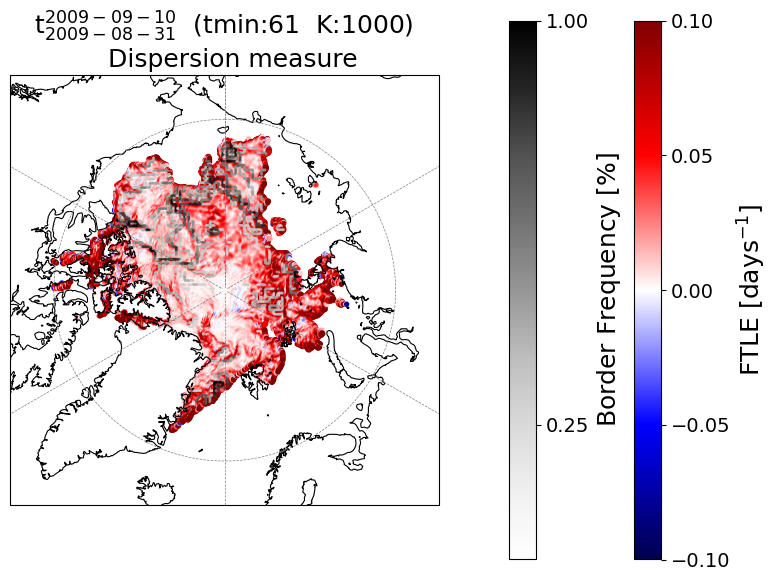

<Figure size 640x480 with 0 Axes>

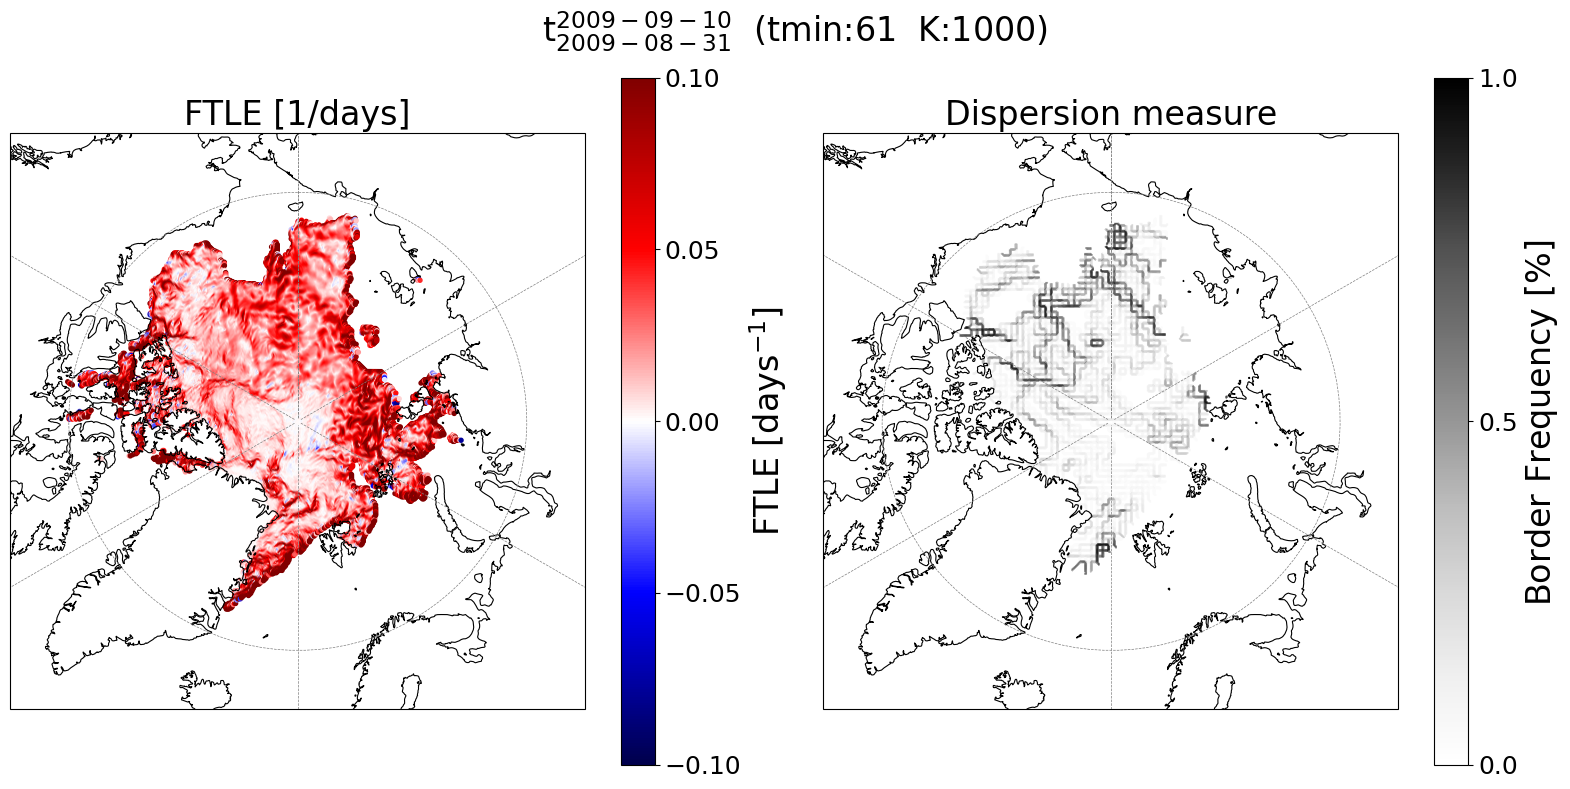

Processing 2 clusters
Processing 3 clusters
Processing 4 clusters
Processing 5 clusters
Processing 6 clusters
Processing 7 clusters
Processing 8 clusters
Processing 9 clusters
Processing 10 clusters
Processing 11 clusters
Processing 12 clusters
Processing 13 clusters
Processing 14 clusters
Processing 15 clusters
Processing 16 clusters
Processing 17 clusters
Processing 18 clusters
Processing 19 clusters
Processing 20 clusters
Processing 21 clusters
Processing 22 clusters
Processing 23 clusters
Processing 24 clusters
Processing 25 clusters
Processing 26 clusters
Processing 27 clusters
Processing 28 clusters
Processing 29 clusters
Processing 30 clusters


<Figure size 640x480 with 0 Axes>

In [7]:

print("Reading regrided input data")
tmin_idx = tmin * 4
tmax_idx = tmin_idx + 10 * 4
t0 = time_data[0, tmin_idx]
t1 = time_data[0, tmax_idx]
FTLE_field = np.load(ftle_path + str(tmin) + "_FTLE.npy")
FTLE_field_plot = np.copy(FTLE_field)
mask = np.isnan(FTLE_field)
exp_mask = cut_trajectories(0,mask,Y_domain,X_domain,canadian=True, eastSval=True, canadian_greenland=True)
FTLE_field[np.isnan(FTLE_field)] = 0
Interpolant_FTLE = interpolant_unsteady_FTLE(X_domain, Y_domain, FTLE_field)

FTLE = []
#FTLE_field[550:552,150:152]

clusters_path =  domain_path+"/"+str(year)+"_"+str(season)+"_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/"
K=1000
min_clusters=2
max_clusters=30
borders_avg_disp = np.zeros(X_domain.shape)
borders_avg_reweighted = np.zeros(X_domain.shape)
k=0
for n_clusters in range(min_clusters, max_clusters+1):
    print("Processing "+str(n_clusters)+" clusters")
    Fmap_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'
    #labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'
    labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'
   
    Fmap= np.load(Fmap_path)
    #labels= np.load(labels_path)
    labels = np.load(labels_path)


    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels, (X_domain,Y_domain), method='nearest')
    
    
    borders = borders_binary(grid_labels)
    borders = np.where(exp_mask, np.nan, borders)
    borders[borders > 0] = 1
    # Accumulate the borders
    borders_avg_disp += borders


    k += 1
    
# After the loop, borders_avg will contain the accumulated borders
borders_avg_disp = np.where(borders_avg_disp == 0, np.nan, borders_avg_disp)
borders_avg_disp = np.where(exp_mask == 1, np.nan, borders_avg_disp)
borders_avg_disp = borders_avg_disp / k

borders_avg_disp_25=np.copy(borders_avg_disp)
borders_avg_disp_25[borders_avg_disp_25<0.25]=np.nan
plotpolar_ftle_avg_2(X_domain, Y_domain, FTLE_field_plot, borders_avg_disp_25, -0.1, 0.1,t0,t1,tmin,K,0.25,"Dispersion",clusters_path+'2_100_borders_over_FTLE_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'.png')
plotpolar_ftle_avg4(X_domain, Y_domain, FTLE_field_plot, borders_avg_disp, -0.1, 0.1,t0,t1,tmin,K,clusters_path+'2_100_borders_side_FTLE_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'.png')

for n_clusters in range (min_clusters, max_clusters+1): 
    print("Processing "+str(n_clusters)+" clusters")
    Fmap_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_labels.npy'
    
    Fmap = np.load(Fmap_path)
    labels= np.load(labels_path)

    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels, (X_domain,Y_domain), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels, (X_domain,Y_domain), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(mask,np.nan, borders_avg)
    borders_idx = np.where(borders_avg==1)
    borders_lon_rot = X_domain[borders_idx]
    borders_lat_rot = Y_domain[borders_idx]
    FTLE.append(Interpolant_FTLE(borders_lat_rot, borders_lon_rot, grid=False))


mean_FTLE = []
idx = []
for i in range(0,len(FTLE)):
    mean_FTLE.append(np.mean(FTLE[i]))
    idx.append(2+i)


np.save(clusters_path+"/2_100_FTLE_interpol_"+str(tmin)+".npy", mean_FTLE)




(0.5, 0.7)

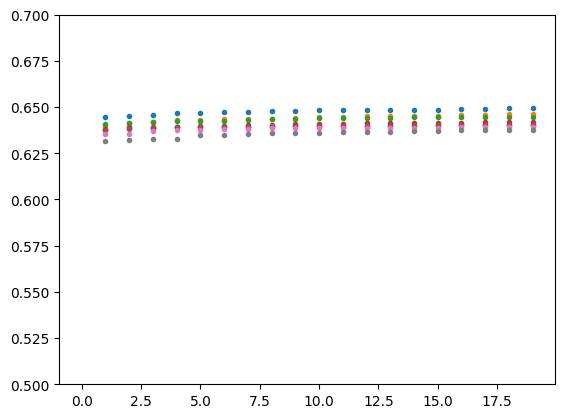

In [8]:
domain_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/"
clusters_path =  domain_path+"/"+str(year)+"_"+str(season)+"_ic0.5_dt0.0025_DT0.0100/disp_clusters_K1000_border0.00_cleaned_center_spars/"

for tmin in range(0,8):
    eigen_path = clusters_path+'tmin'+str(int(tmin))+'_spar'+str(formatted_spar)+'_eigenvalues.npy'
    eigen = np.load(eigen_path)
    plt.plot(eigen[0:20], ".")
plt.ylim(ymin=0.5, ymax=0.7)

    




